### Try-it 9.2: Predicting Wages

This activity is meant to summarize your work with regularized regression models.  You will use your earlier work with data preparation and pipelines together with what you've learned with grid searches to determine an optimal model.  In addition to the prior strategies, this example is an excellent opportunity to utilize the `TransformedTargetRegressor` estimator in scikitlearn.

### The Data

This dataset is loaded from the OpenML resource library.  Originally from census data, the data contains wage and demographic information on 534 individuals. From the dataset documentation [here](https://www.openml.org/d/534)

```
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence, and union membership. 
```

In [1]:
#from sklearn.datasets import fetch_openml
import pandas as pd

In [10]:
# Read the local CSV file
wages_df = pd.read_csv('data/wage.csv')

# Separate features and target
X = wages_df.drop(['wage', 'rownames', 'logwage'], axis=1)
y = wages_df['wage']

# Define numeric and categorical columns
numeric_features = ['year', 'age']  # removed education as it's actually categorical
categorical_features = ['maritl', 'race', 'region', 'jobclass', 'health', 'health_ins', 'education']  # added education here


# Create preprocessing transformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop='first', sparse_output=False), categorical_features)  # Changed sparse to sparse_output
)

print("Features shape:", X.shape)
print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)

Features shape: (3000, 9)

Numeric features: ['year', 'age']
Categorical features: ['maritl', 'race', 'region', 'jobclass', 'health', 'health_ins', 'education']


#### Task

Build regression models to predict `WAGE`.  Incorporate the categorical features and transform the target using a logarithm.  Build `Ridge` models and consider some different amounts of regularization.  

After fitting your model, interpret the model and try to understand what features led to higher wages.  Consider using `permutation_importance` that you encountered in module 8.  Discuss your findings in the class forum.

For an in depth example discussing the perils of interpreting the coefficients, see the example in scikitlearn examples [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
import numpy as np
import plotly.express as px
import pandas as pd
import warnings

Best parameters: {'regressor__regressor__alpha': 0.1}
Best CV score: 1171.5507 MSE


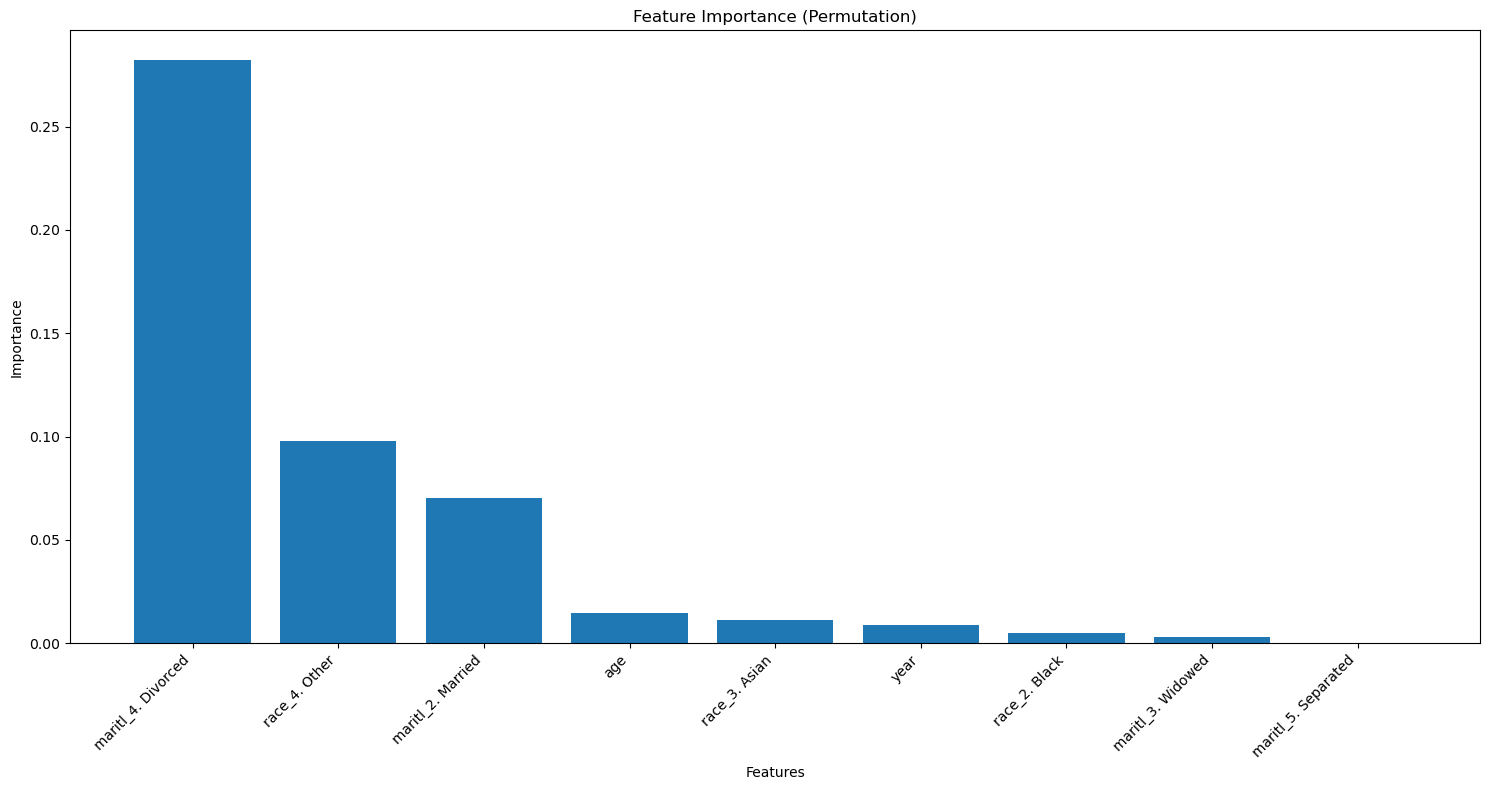


Top 10 most important features:
               feature  importance       std
4   maritl_4. Divorced    0.282422  0.013609
8        race_4. Other    0.098107  0.007683
2    maritl_2. Married    0.070482  0.006119
1                  age    0.014451  0.001944
7        race_3. Asian    0.011443  0.001660
0                 year    0.008816  0.002696
6        race_2. Black    0.004876  0.000869
3    maritl_3. Widowed    0.002927  0.001013
5  maritl_5. Separated    0.000000  0.000000


In [16]:
import matplotlib.pyplot as plt

# Create pipeline with target transformation
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', TransformedTargetRegressor(
        regressor=Ridge(),
        func=np.log,
        inverse_func=np.exp
    ))
])

# Define parameter grid
param_grid = {
    'regressor__regressor__alpha': [0.1, 1.0, 10.0, 100.0]
}

# Perform grid search
grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit the model
grid_search.fit(X, y)

# Print best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {-grid_search.best_score_:.4f} MSE")

# Get transformed feature names first
encoder = grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['onehotencoder']
feature_names = []

# Add numeric feature names
feature_names.extend(numeric_features)

# Add encoded categorical feature names
for i, feature in enumerate(categorical_features):
    cats = encoder.categories_[i][1:]  # Skip first category due to drop='first'
    feature_names.extend([f"{feature}_{cat}" for cat in cats])

# Calculate permutation importance
result = permutation_importance(
    grid_search.best_estimator_,
    X,
    y,
    n_repeats=10,
    random_state=42
)

# Create importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names[:len(result.importances_mean)],
    'importance': result.importances_mean,
    'std': result.importances_std
})

# Sort by importance
importance_df = importance_df.sort_values('importance', ascending=False)

# Plot with matplotlib
plt.figure(figsize=(15, 8))
plt.bar(range(len(importance_df)), importance_df['importance'])
plt.xticks(range(len(importance_df)), importance_df['feature'], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance (Permutation)')
plt.tight_layout()
plt.show()

# Print top 10 most important features
print("\nTop 10 most important features:")
print(importance_df.head(10))